In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
from google.cloud import storage

%load_ext google.cloud.bigquery

In [3]:
demoDf = pd.read_csv('./data/us_demography.csv')
demoDf.head()

,FIPS,State_FIP,State,StateName,County,Urban,Population,Frac65Plus,PopDensity
0,1001,1,AL,Alabama,Autauga County,2.0,55601,0.155627,93.534462
1,1003,1,AL,Alabama,Baldwin County,3.0,218022,0.204433,137.136021
2,1005,1,AL,Alabama,Barbour County,6.0,24881,0.194204,28.113870
3,1007,1,AL,Alabama,Bibb County,1.0,22400,0.164732,35.986190
4,1009,1,AL,Alabama,Blount County,1.0,57840,0.182365,89.697921


In [4]:
stateDemoDf = demoDf.copy()
stateDemoDf["elderlyPop"] = stateDemoDf[["Population", "Frac65Plus"]].apply(lambda x: x[0]*x[1], axis=1)
stateDemoDf["landArea"] = stateDemoDf[["Population", "PopDensity"]].apply(lambda x: x[0]/x[1], axis=1)
stateDemoDf = stateDemoDf.groupby(["State_FIP", "State", "StateName"]).agg({"Urban":"median",
                                                              "Population":"sum",
                                                              "elderlyPop":"sum",
                                                              "landArea":"sum"
                                                             }).reset_index()
stateDemoDf["Frac65Plus"] = stateDemoDf[["Population", "elderlyPop"]].apply(lambda x: x[1]/x[0], axis=1)
stateDemoDf["PopDensity"] = stateDemoDf[["Population", "landArea"]].apply(lambda x: x[0]/x[1], axis=1)
stateDemoDf.head()

,State_FIP,State,StateName,Urban,Population,elderlyPop,landArea,Frac65Plus,PopDensity
0,1,AL,Alabama,4.0,4887871,826894.0,50646.639,0.169173,96.509287
1,2,AK,Alaska,9.0,737438,87011.0,571016.948,0.117991,1.291447
2,4,AZ,Arizona,3.0,7171646,1258250.0,113653.146,0.175448,63.101166
3,5,AR,Arkansas,6.0,3013825,511827.0,52037.528,0.169826,57.916375
4,6,CA,California,2.5,39557045,5669025.0,155854.041,0.143313,253.808273


## Using Google Big Query to get cases data

- There is mixture of data granularity

In [5]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'project-key.json'

In [52]:
%%bigquery earlyDf

SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary`
WHERE  country_region = 'US'
AND confirmed > 0
AND province_state LIKE '%County%'
ORDER BY date

In [53]:
# earlyDf = pd.read_csv("./data/cases_early_counties.csv")
error_raw_states = set()
def clean_early(row):
    raw_state = row["province_state"]
    raw_state = raw_state.strip()
    county, state = raw_state.split(",")
    county = county.strip()
    state = state.strip()
    lookupDf = demoDf[(demoDf["County"] == county) & (demoDf["State"] == state)]
    if lookupDf.shape[0] == 1:
        lookup = lookupDf.iloc[0]
    else:
        print("Error for :", raw_state)
        error_raw_states.add(raw_state)
        return row
    row["admin2"] = lookup["County"].replace("County", "").strip()
    row["fips"] = lookup["FIPS"]
    row["province_state"] = lookup["StateName"]
    return row
earlyDf = earlyDf.apply(lambda row: clean_early(row), axis=1)
earlyDf = earlyDf[~earlyDf["province_state"].isin(error_raw_states)]
earlyDf["fips"] = earlyDf["fips"].astype('int64')
demoFeatures = ["FIPS", "State_FIP", "State", "Urban", "Population", "Frac65Plus", "PopDensity"]
earlyDf = earlyDf.merge(demoDf[demoFeatures], left_on="fips", right_on="FIPS", how="left")
earlyDf = earlyDf.drop("FIPS", axis=1)
print(earlyDf.shape)
earlyDf.head()

Error for : Norwell County, MA
(404, 19)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116


In [54]:
%%bigquery midDf
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary`
WHERE  country_region = 'US'
AND confirmed > 0
AND date >= '2020-03-09' AND date <='2020-03-22'
AND fips is NULL AND admin2 is NULL
AND NOT province_state LIKE '%County%'
ORDER BY date

In [55]:
# midDf = pd.read_csv("./data/cases_mar10_mar22_states.csv")
demoSFeatures = ["State_FIP", "State", "StateName", "Urban", "Population", "Frac65Plus", "PopDensity"]
midDf = midDf.merge(stateDemoDf[demoSFeatures], left_on="province_state", right_on="StateName", how="inner")
midDf["fips"] = midDf["State_FIP"]
midDf = midDf.drop(["StateName"], axis=1)
print(midDf.shape)
midDf.tail()

(589, 19)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity
584,West Virginia,US,2020-03-17,38.4912,-80.9545,POINT(-80.9545 38.4912),1,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
585,West Virginia,US,2020-03-18,38.4912,-80.9545,POINT(-80.9545 38.4912),1,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
586,West Virginia,US,2020-03-19,38.4912,-80.9545,POINT(-80.9545 38.4912),2,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
587,West Virginia,US,2020-03-20,38.4912,-80.9545,POINT(-80.9545 38.4912),7,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
588,West Virginia,US,2020-03-21,38.4912,-80.9545,POINT(-80.9545 38.4912),8,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279


In [56]:
midStart = midDf.groupby("province_state")["date"].min().reset_index()
midStart = midStart.rename(columns={"date":"date1"})
earlyStart = earlyDf.groupby(["province_state"])["date"].min().reset_index()
approxStart = stateDemoDf[["State_FIP", "State", "StateName"]].merge(earlyStart, left_on="StateName", right_on="province_state", how="left", )
approxStart = approxStart.merge(midStart, left_on="StateName", right_on="province_state", how="left")
def approx_startdate(dateEarly, dateMid):
    if pd.isnull(dateEarly):
        return dateMid
    else:
        return dateEarly
approxStart["startDate"] = approxStart[["date", "date1"]].apply(lambda x: approx_startdate(x[0], x[1]), axis=1)
approxStart = approxStart.drop(["province_state_x", "province_state_y", "date1", "date"], axis=1)
approxStart.tail()

,State_FIP,State,StateName,startDate
47,53,WA,Washington,2020-02-29
48,54,WV,West Virginia,2020-03-17
49,55,WI,Wisconsin,2020-03-10
50,56,WY,Wyoming,2020-03-12
51,72,PR,Puerto Rico,2020-03-14


In [43]:
%%bigquery casesDf

SELECT * FROM `bigquery-public-data.covid19_jhu_csse_eu.summary`
WHERE  country_region = 'US'
AND fips is not NULL
ORDER BY date;

In [57]:
casesDf["fips"] = casesDf["fips"].astype("int64")
demoFeatures = ["FIPS", "State_FIP", "State", "Urban", "Population", "Frac65Plus", "PopDensity"]
combinedDf = casesDf.merge(demoDf[demoFeatures], left_on="fips", right_on="FIPS", how="inner")
combinedDf = combinedDf.drop("FIPS", axis=1)
combinedDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity
0,Iowa,US,2020-03-22,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,IA,8.0,6841,0.222044,15.853704
1,Iowa,US,2020-03-23,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,IA,8.0,6841,0.222044,15.853704
2,Iowa,US,2020-03-24,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,IA,8.0,6841,0.222044,15.853704
3,Iowa,US,2020-03-25,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,IA,8.0,6841,0.222044,15.853704
4,Iowa,US,2020-03-26,42.386961,-95.513554,POINT(-95.51355387 42.38696136),0,0,0,0,19093,Ida,"Ida, Iowa, US",19,IA,8.0,6841,0.222044,15.853704


In [58]:
prDf = casesDf[casesDf["admin2"].isna()].merge(demoDf[demoFeatures], left_on="fips", right_on="State_FIP", how="inner")
prDf = prDf.drop("FIPS", axis=1)
casesDemoDf = pd.concat([earlyDf, midDf, combinedDf, prDf], sort=False)
casesDemoDf = casesDemoDf.merge(approxStart[["State_FIP", "startDate"]], on="State_FIP", how="left")
casesDemoDf["startDate"].isna().sum()

0

In [60]:
print(prDf.shape)
casesDemoDf.head()

(1950, 19)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity,startDate
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11


In [61]:
casesDemoDf["date"] = pd.to_datetime(casesDemoDf["date"])
casesDemoDf["startDate"] = pd.to_datetime(casesDemoDf["startDate"])
casesDemoDf["approxDays"] = (casesDemoDf["date"] - casesDemoDf["startDate"]).dt.days + 1
casesDemoDf["approxDays"] = casesDemoDf["approxDays"].astype('int64')
casesDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity,startDate,approxDays
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,1
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,2
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,3
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,4
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,5


In [62]:
casesDemoDf['casesPer1M'] = casesDemoDf[["Population", "confirmed"]].apply(lambda x: x[1]*1e6/x[0], axis=1).astype('float64')
casesDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity,startDate,approxDays,casesPer1M
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,1,0.2991
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,2,0.2991
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,3,0.5982
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,4,0.5982
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,5,0.5982


### Adding Interventions information

In [63]:
# cleaned data from https://github.com/Keystone-Strategy/covid19-intervention-data
intDf = pd.read_csv("./data/npis_lookup.csv")
intCols = intDf.columns.values
print(intDf.shape)
print(intCols)
intDf.head()

(384, 12)
['fip_code' 'gathering_size_500_to_101' 'gathering_size_100_to_26'
 'gathering_size_25_to_11' 'gathering_size_10_0' 'school_closure'
 'closing_of_public_venues' 'non-essential_services_closure'
 'social_distancing' 'shelter_in_place' 'religious_gatherings_banned'
 'lockdown']


,fip_code,gathering_size_500_to_101,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown
0,1,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-20,2020-03-28,2020-03-28,2020-04-03,2020-04-04,2020-04-04,NaN
1,2,2020-03-24,2020-03-24,2020-03-24,2020-03-24,2020-03-16,2020-03-18,2020-03-28,2020-03-28,2020-03-28,2020-03-24,NaN
2,4,NaN,NaN,NaN,NaN,2020-03-15,2020-03-31,2020-03-31,2020-03-31,2020-03-31,NaN,NaN
3,5,2020-03-27,2020-03-27,2020-03-27,2020-03-27,2020-03-19,2020-03-20,2020-04-06,2020-03-27,NaN,NaN,NaN
4,6,2020-03-11,2020-03-16,2020-03-16,2020-03-16,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,NaN


In [64]:
caseIntCountiesDf = casesDemoDf.merge(intDf, left_on="fips", right_on="fip_code", how="left")
caseIntStatesDf = caseIntCountiesDf[caseIntCountiesDf['fip_code'].isna()]
caseIntCountiesDf = caseIntCountiesDf[~caseIntCountiesDf['fip_code'].isna()]
caseIntStatesDf = caseIntStatesDf.drop(intCols, axis=1)
caseIntStatesDf = caseIntStatesDf.merge(intDf, left_on="State_FIP", right_on="fip_code", how="left")
caseIntDemoDf = pd.concat([caseIntStatesDf,caseIntCountiesDf], sort=False)
print(caseIntDemoDf.shape)
caseIntDemoDf.sample(5)

(101333, 34)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown
85552,South Carolina,US,2020-04-20,33.219276,-81.056600,POINT(-81.05659969 33.21927586),7,0,0,7,...,2020-03-17,2020-03-23,2020-03-23,2020-03-16,2020-03-18,2020-03-31,2020-03-21,2020-04-07,NaN,NaN
8747,Texas,US,2020-04-08,31.430522,-102.514331,POINT(-102.5143314 31.43052248),2,0,0,0,...,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-04-02,2020-03-20,NaN,NaN,NaN
1989,Iowa,US,2020-04-02,42.470919,-91.835108,POINT(-91.83510825 42.4709188),3,0,0,0,...,2020-03-17,2020-03-17,2020-03-17,2020-03-16,2020-03-17,2020-03-17,NaN,NaN,2020-03-17,NaN
88454,Pennsylvania,US,2020-03-27,41.059341,-75.340310,POINT(-75.34031025 41.05934058),98,2,0,0,...,NaN,NaN,NaN,2020-03-16,2020-03-19,2020-03-21,NaN,2020-03-31,2020-04-01,NaN
51411,Nebraska,US,2020-03-26,40.506633,-98.948772,POINT(-98.94877182 40.50663314),0,0,0,0,...,2020-03-16,2020-04-03,2020-04-03,2020-04-03,2020-03-16,2020-04-03,NaN,NaN,2020-04-03,NaN


In [65]:
def encode_intervention_info(row):
    date = row["date"]
    total_int = 0
    for col in intCols[1:]:
        intDate = row[col]
        if pd.isnull(intDate) or intDate > str(date):
            row[col] = 0
        else:
            row[col] = 1
            total_int += 1
    row["totalInt"] = total_int
    return row

caseIntDemoDf = caseIntDemoDf.apply(lambda row: encode_intervention_info(row), axis=1)

In [66]:
caseIntDemoDf.sample(5)

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt
32098,Montana,US,2020-03-23,45.939559,-108.269149,POINT(-108.2691486 45.93955949),6,0,0,0.0,...,0,0,1,0,0,0,0,0,0,1
51567,Nebraska,US,2020-04-12,41.166243,-98.037489,POINT(-98.0374887 41.16624273),2,0,0,2.0,...,1,1,1,1,1,0,0,1,0,8
40265,Illinois,US,2020-04-24,39.231988,-89.478093,POINT(-89.47809254 39.23198845),23,1,0,22.0,...,1,1,1,1,1,1,1,1,0,10
80018,California,US,2020-03-28,34.840603,-116.177469,POINT(-116.1774685 34.84060306),76,3,0,0.0,...,1,1,1,1,1,1,1,1,0,10
20057,Alabama,US,2020-03-27,33.720769,-87.738866,POINT(-87.73886638 33.72076938),0,0,0,0.0,...,1,0,1,0,0,0,0,0,0,4


In [67]:
# Number of data records with no interventions
caseIntDemoDf[caseIntDemoDf['totalInt']==0].shape

(804, 35)

### Adding International Flights Info

In [68]:
# Cleaned data from https://opensky-network.org/datasets/covid-19/
# Only available upto 31 March. Considering 0 for missing data as there are not much flights
flightsDf = pd.read_csv("./data/aggregatedFlights.csv")
flightsDf = flightsDf.merge(stateDemoDf[["State_FIP", "State"]], left_on="state_abbreviation", right_on="State", how="left")
flightsDf = flightsDf.rename(columns={'destination':'flights'})
flightsDf.head()

,state_abbreviation,week,day,flights,State_FIP,State
0,AK,1,2020-01-01,100,2,AK
1,AK,2,2020-01-06,148,2,AK
2,AK,3,2020-01-13,160,2,AK
3,AK,4,2020-01-20,120,2,AK
4,AK,5,2020-01-27,77,2,AK


In [69]:
caseIntDemoDf["week"] = caseIntDemoDf["date"].dt.week - 1
caseIntDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,8
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,8


In [70]:
caseIntDemoDf = caseIntDemoDf.merge(flightsDf[["State_FIP", "week", "flights"]], on=["State_FIP", "week"], how="left")
caseIntDemoDf["flights"] = caseIntDemoDf["flights"].fillna(0.0)
caseIntDemoDf = caseIntDemoDf.rename(columns = {"flights": "flights_prev_week"})
caseIntDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,8,854.0
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,8,854.0


### Adding climatic information

In [71]:
%%bigquery tempDf

SELECT date, state, AVG(data.value) as tavg FROM `bigquery-public-data.ghcn_d.ghcnd_2020` as data
INNER JOIN (
SELECT st.id as stId, st.state as state FROM `bigquery-public-data.ghcn_d.ghcnd_stations` st
WHERE st.state in ( SELECT code FROM  `bigquery-public-data.ghcn_d.ghcnd_states`)
-- AND st.id LIKE 'US%'
) as us_st
ON data.id = us_st.stId 
WHERE data.element = 'TMAX'
GROUP BY date, state
ORDER BY date,state

In [72]:
tempDf["tavg"] = tempDf["tavg"]/10
tempDf = tempDf.merge(stateDemoDf[["State_FIP", "State"]], left_on="state", right_on="State", how="inner")
tempDf.head()

,date,state,tavg,State_FIP,State
0,2020-01-01,AK,-9.348026,2,AK
1,2020-01-02,AK,-14.129373,2,AK
2,2020-01-03,AK,-16.310299,2,AK
3,2020-01-04,AK,-18.741860,2,AK
4,2020-01-05,AK,-19.888926,2,AK


In [73]:
tempDf["date"] = pd.to_datetime(tempDf["date"])
tempDf["week"] = tempDf["date"].dt.week
tempDf.sample(10)

,date,state,tavg,State_FIP,State,week
2050,2020-03-20,LA,26.624138,22,LA,12
3731,2020-01-21,NV,6.910843,32,NV,4
3153,2020-01-23,ND,-1.720238,38,ND,4
5068,2020-03-22,TX,16.682596,48,TX,12
3606,2020-01-12,NM,7.155944,35,NM,2
2927,2020-01-29,MT,3.716997,30,MT,5
3155,2020-01-25,ND,-2.158333,38,ND,4
639,2020-02-29,CO,9.353179,8,CO,9
4006,2020-03-04,OH,11.968605,39,OH,10
5803,2020-01-05,WY,0.192593,56,WY,1


In [74]:
aggTempDf = tempDf.groupby(["week", "State_FIP", "state"])["tavg"].mean().reset_index()
aggTempDf.tail()

,week,State_FIP,state,tavg
862,17,53,WA,13.335141
863,17,54,WV,15.433081
864,17,55,WI,11.140047
865,17,56,WY,12.340585
866,17,72,PR,29.941595


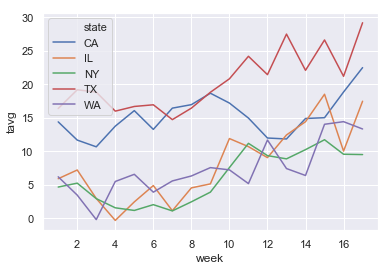

In [75]:
sns.lineplot(x="week", y="tavg", data=aggTempDf[aggTempDf["state"].isin(["NY", "WA", "IL", "CA", "TX"])], hue="state")

In [76]:
casesAllDf = caseIntDemoDf.merge(aggTempDf[["State_FIP","state", "week", "tavg"]], on=["week", "State_FIP"], how="left")
casesAllDf = casesAllDf.rename(columns={"tavg":"avg_temp_prev_week"})
casesAllDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week,state,avg_temp_prev_week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,7,774.0,CA,16.449679
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,7,774.0,CA,16.449679
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,7,774.0,CA,16.449679
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,8,854.0,CA,16.969811
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,8,854.0,CA,16.969811


## Imputing missing temperature values using mean temperature that week

In [77]:
# casesAllDf[casesAllDf["avg_temp_prev_week"].isna()]
tempFillerDict = casesAllDf.groupby("week")["avg_temp_prev_week"].mean().to_dict()
casesAllDf["avg_temp_prev_week"] = casesAllDf[["week", "avg_temp_prev_week"]].apply(
    lambda x: tempFillerDict[x[0]] if pd.isnull(x[1]) else x[1], axis=1)
casesAllDf.tail(10)

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week,state,avg_temp_prev_week
101323,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101324,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101325,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101326,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101327,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101328,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101329,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101330,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101331,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161
101332,Puerto Rico,US,2020-04-26,18.2208,-66.5901,POINT(-66.5901 18.2208),1371,84,0,1287.0,...,1,1,0,1,1,10,16,0.0,PR,29.597161


In [85]:
casesAllDf["state"] = casesAllDf["state"].fillna("DC")
casesAllDf.isna().sum()

province_state                       0
country_region                       0
date                                 0
latitude                            38
longitude                           38
location_geom                       38
confirmed                            0
deaths                               0
recovered                            0
active                             992
fips                                 0
admin2                            2539
combined_key                       992
State_FIP                            0
State                                0
Urban                                0
Population                           0
Frac65Plus                           0
PopDensity                           0
startDate                            0
approxDays                           0
casesPer1M                           0
fip_code                             0
gathering_size_500_to_101            0
gathering_size_100_to_26             0
gathering_size_25_to_11  

In [86]:
casesAllDf.columns

Index(['province_state', 'country_region', 'date', 'latitude', 'longitude',
       'location_geom', 'confirmed', 'deaths', 'recovered', 'active', 'fips',
       'admin2', 'combined_key', 'State_FIP', 'State', 'Urban', 'Population',
       'Frac65Plus', 'PopDensity', 'startDate', 'approxDays', 'casesPer1M',
       'fip_code', 'gathering_size_500_to_101', 'gathering_size_100_to_26',
       'gathering_size_25_to_11', 'gathering_size_10_0', 'school_closure',
       'closing_of_public_venues', 'non-essential_services_closure',
       'social_distancing', 'shelter_in_place', 'religious_gatherings_banned',
       'lockdown', 'totalInt', 'week', 'flights_prev_week', 'state',
       'avg_temp_prev_week'],
      dtype='object')

In [87]:
features = ['approxDays', 'Urban',
       'Frac65Plus', 'PopDensity', 'gathering_size_500_to_101', 'gathering_size_100_to_26',
       'gathering_size_25_to_11', 'gathering_size_10_0', 'school_closure',
       'closing_of_public_venues', 'non-essential_services_closure',
       'social_distancing', 'shelter_in_place', 'religious_gatherings_banned',
       'lockdown', 'flights_prev_week',
       'avg_temp_prev_week','casesPer1M']
featuresDf = casesAllDf[features]
featuresDf.head()

,approxDays,Urban,Frac65Plus,PopDensity,gathering_size_500_to_101,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,flights_prev_week,avg_temp_prev_week,casesPer1M
0,11,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
1,12,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
2,13,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
3,14,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,854.0,16.969811,7.33283
4,15,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,854.0,16.969811,7.33283


In [88]:
featuresDf.to_csv("./data/us_covid19_features.csv", index=False)

In [89]:
casesAllDf.to_csv("./data/raw_us_covid19_features.csv", index=False)